In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from glob import glob
import io
import os
import math
import json
import pprint
from plydata import define, query, select, head, do, group_by, summarize, arrange, left_join, distinct
import duckdb

from tabulate import tabulate
def print_table(table):
    print(tabulate(table, headers='keys', showindex=False, tablefmt='presto'))

In [104]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
gender_submission_df = pd.read_csv('gender_submission.csv')

In [105]:
print("{} samples found in the training dataset and {} samples found in the testing dataset".format(len(train_df), len(test_df)))

891 samples found in the training dataset and 418 samples found in the testing dataset


In [106]:
test_data_ind_col = 'TestData'
train_df[test_data_ind_col] = 0
test_df[test_data_ind_col] = 1

df = pd.concat([train_df, pd.merge(test_df, gender_submission_df, on=['PassengerId'])[train_df.columns]])

In [107]:
print_table(df >> head())

   PassengerId |   Survived |   Pclass | Name                                                | Sex    |   Age |   SibSp |   Parch | Ticket           |    Fare | Cabin   | Embarked   |   TestData
---------------+------------+----------+-----------------------------------------------------+--------+-------+---------+---------+------------------+---------+---------+------------+------------
             1 |          0 |        3 | Braund, Mr. Owen Harris                             | male   |    22 |       1 |       0 | A/5 21171        |  7.25   | nan     | S          |          0
             2 |          1 |        1 | Cumings, Mrs. John Bradley (Florence Briggs Thayer) | female |    38 |       1 |       0 | PC 17599         | 71.2833 | C85     | C          |          0
             3 |          1 |        3 | Heikkinen, Miss. Laina                              | female |    26 |       0 |       0 | STON/O2. 3101282 |  7.925  | nan     | S          |          0
             4 |        

In [108]:
df.isna().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
TestData          0
dtype: int64

In [109]:
print_table(df >> group_by('Cabin') >> summarize(cnt='n()') >> head())

 Cabin   |   cnt
---------+-------
 C85     |     2
 C123    |     2
 E46     |     2
 G6      |     5
 C103    |     1


In [110]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'TestData'],
      dtype='object')

In [111]:
print_table(df >> group_by('Embarked') >> summarize(cnt='n()'))

 Embarked   |   cnt
------------+-------
 S          |   914
 C          |   270
 Q          |   123


In [112]:
categorical_columns = ['Sex', 'Embarked']

data = pd.concat([df, pd.get_dummies(df[categorical_columns], 
                                     drop_first=True,  
                                     dtype='int', 
                                     prefix=categorical_columns, 
                                     prefix_sep='Is')], axis=1
                )

In [113]:
print_table(data >> head())

   PassengerId |   Survived |   Pclass | Name                                                | Sex    |   Age |   SibSp |   Parch | Ticket           |    Fare | Cabin   | Embarked   |   TestData |   SexIsmale |   EmbarkedIsQ |   EmbarkedIsS
---------------+------------+----------+-----------------------------------------------------+--------+-------+---------+---------+------------------+---------+---------+------------+------------+-------------+---------------+---------------
             1 |          0 |        3 | Braund, Mr. Owen Harris                             | male   |    22 |       1 |       0 | A/5 21171        |  7.25   | nan     | S          |          0 |           1 |             0 |             1
             2 |          1 |        1 | Cumings, Mrs. John Bradley (Florence Briggs Thayer) | female |    38 |       1 |       0 | PC 17599         | 71.2833 | C85     | C          |          0 |           0 |             0 |             0
             3 |          1 |      

In [114]:
data.isna().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
TestData          0
SexIsmale         0
EmbarkedIsQ       0
EmbarkedIsS       0
dtype: int64

In [115]:
data['Age'].mean()

29.881137667304014

In [116]:
print_table(data >> summarize(avg_age='mean(Age)'))

   avg_age
-----------
   29.8811


In [117]:
data['AgeImputed'] = data['Age'].fillna(value=data['Age'].mean(), inplace=False)
data['FareImputed'] = data['Fare'].fillna(value=data['Fare'].mean(), inplace=False)

In [118]:
data.isna().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
TestData          0
SexIsmale         0
EmbarkedIsQ       0
EmbarkedIsS       0
AgeImputed        0
FareImputed       0
dtype: int64

In [123]:
data = data.rename(columns={"SexIsmale": "SexIsMale"})

In [128]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'TestData', 'SexIsMale',
       'EmbarkedIsQ', 'EmbarkedIsS', 'AgeImputed', 'FareImputed'],
      dtype='object')

In [124]:
from sklearn.model_selection import train_test_split

In [133]:
features = [
    'Pclass', 
    # 'Name', 
    # 'Sex', 
    # 'Age', 
    'SibSp', 
    'Parch', 
    # # 'Ticket', 
    # 'Fare', 
    # 'Cabin', 
    'SexIsMale',
    'EmbarkedIsQ', 
    'EmbarkedIsS', 
    'AgeImputed', 
    'FareImputed'
]

target = 'Survived'

In [134]:
X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)

In [135]:
# Normalize the data to avoid Vanishing gradient

from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [137]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

classifiers  = {
    'Logistic Regression' : LogisticRegression(solver='lbfgs'),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=20),
    'GaussianNB': GaussianNB(),
    'SVM': SVC(gamma='auto'),
    'KNN': KNeighborsClassifier(n_neighbors=10),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=5)
}

In [144]:
from sklearn.model_selection import KFold, cross_val_score, cross_validate

print('=' * 100)
for name in classifiers:
    print(name)
    print('=' * 100)
    classifier = classifiers[name]
    kflod = KFold(n_splits=10, random_state=100, shuffle=True)
    cv_res = cross_validate(classifier, X_train, y_train, cv=kflod, scoring=('recall', 'precision', 'f1'))
    print('{}: {:.3f} (+/-{:.3f})'.format('Recall', cv_res['test_recall'].mean(), cv_res['test_recall'].std()))
    print('{}: {:.3f} (+/-{:.3f})'.format('Precision', cv_res['test_precision'].mean(), cv_res['test_precision'].std()))
    print('{}: {:.3f} (+/-{:.3f})'.format('F1', cv_res['test_f1'].mean(), cv_res['test_f1'].std()))
    print('=' * 100)

Logistic Regression
Recall: 0.785 (+/-0.057)
Precision: 0.834 (+/-0.096)
F1: 0.803 (+/-0.036)
Decision Tree
Recall: 0.752 (+/-0.072)
Precision: 0.738 (+/-0.091)
F1: 0.741 (+/-0.061)
Random Forest
Recall: 0.764 (+/-0.086)
Precision: 0.807 (+/-0.100)
F1: 0.778 (+/-0.056)
GaussianNB
Recall: 0.794 (+/-0.058)
Precision: 0.786 (+/-0.103)
F1: 0.783 (+/-0.036)
SVM
Recall: 0.788 (+/-0.055)
Precision: 0.834 (+/-0.096)
F1: 0.805 (+/-0.038)
KNN
Recall: 0.735 (+/-0.073)
Precision: 0.833 (+/-0.096)
F1: 0.775 (+/-0.043)
Gradient Boosting
Recall: 0.738 (+/-0.075)
Precision: 0.851 (+/-0.096)
F1: 0.784 (+/-0.048)


In [145]:
### Let's use Random Forest to do the grid search
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [151]:
# Number of trees in random forest
n_estimators = list(range(10, 110, 10))

# Number of features to consider at every split
max_features = ['sqrt']

# Maximum number of levels in tree
max_depth = list(range(1,4))

# Minimum number of samples required to split a node
min_samples_split = [3, 5, 8]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the param grid
param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

param_grid

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'max_features': ['sqrt'],
 'max_depth': [1, 2, 3],
 'min_samples_split': [3, 5, 8],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [152]:
grid_search_cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, scoring = 'f1', n_jobs=-1)

In [153]:
%%time
grid_search_cv.fit(X_train, y_train)

CPU times: user 2.62 s, sys: 531 ms, total: 3.15 s
Wall time: 43.5 s


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [1, 2, 3],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [3, 5, 8],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             scoring='f1')

In [154]:
model = grid_search_cv.best_estimator_

In [156]:
model

RandomForestClassifier(bootstrap=False, max_depth=3, min_samples_leaf=2,
                       min_samples_split=8, n_estimators=30)

In [157]:
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, confusion_matrix, roc_auc_score

In [158]:
feature_imp = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

print(feature_imp)

SexIsMale      0.640008
FareImputed    0.125349
Pclass         0.064729
AgeImputed     0.056303
Parch          0.042268
EmbarkedIsS    0.031272
SibSp          0.025683
EmbarkedIsQ    0.014388
dtype: float64


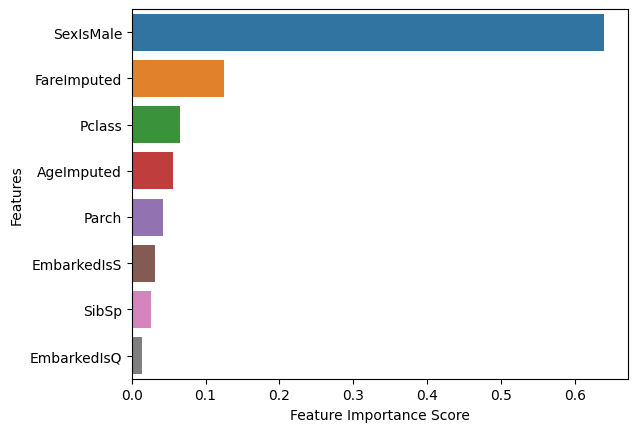

In [159]:
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()

In [160]:
y_pred = model.predict(X_test)

y_pred_proba = model.predict_proba(X_test)[:,1]

In [162]:
# model eveulation metrics
print('Recall: {}'.format(recall_score(y_test, y_pred)))
print('Precision: {}'.format(precision_score(y_test, y_pred)))
print('F1: {}'.format(f1_score(y_test, y_pred)))
print('AUC: {}'.format(roc_auc_score(y_test, y_pred_proba)))

Recall: 0.7763157894736842
Precision: 0.8137931034482758
F1: 0.7946127946127947
AUC: 0.87864435466259


In [163]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[214  27]
 [ 34 118]]


In [164]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       241
           1       0.81      0.78      0.79       152

    accuracy                           0.84       393
   macro avg       0.84      0.83      0.83       393
weighted avg       0.84      0.84      0.84       393



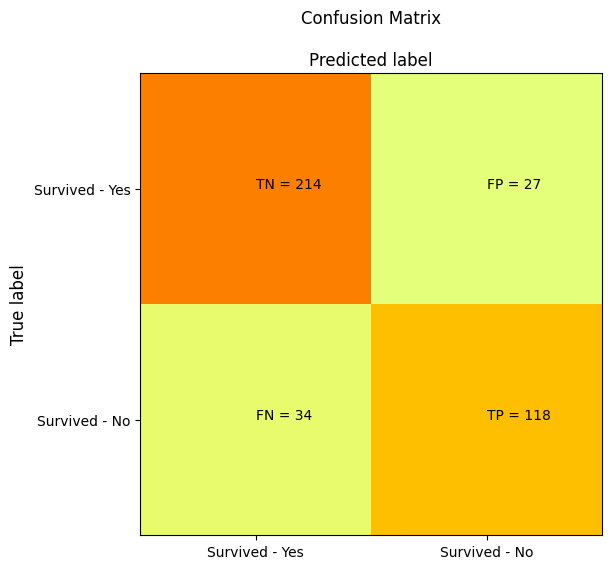

In [173]:
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classes = ['Survived - Yes','Survived - No']
plt.title('Confusion Matrix\n\nPredicted label')
plt.ylabel('True label', size=12)
# plt.xlabel('Predicted label')
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=0)
plt.yticks(tick_marks, classes)
labels = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(labels[i][j])+" = "+str(cm[i][j]))
plt.show()